## Event camera demo (color event)
**By Cedric Scheerlinck**  
Tested on python3.7.5 and python3.7.6  
Description: load and visualize events from a small dataset.  
Based on: https://github.com/cedric-scheerlinck/dvs_image_reconstruction  

**Video:** https://youtu.be/bZ0ZKido0Ag

Note: If interact doesn't work, try enabling ipywidgets:  
```jupyter nbextension enable --py widgetsnbextension```  
and restarting jupyter notebook.

In [1]:
from ipywidgets import interact, fixed, interact_manual, FloatSlider, IntSlider
import math
%matplotlib notebook
from matplotlib import rc
rc('animation', html='jshtml')
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation

# local modules
from util import Timer, Event, normalize_image, animate, load_events, plot_3d, event_slice

In [2]:
def animate_color(images, fig_title=''):
    fig = plt.figure(figsize=(0.1, 0.1))  # don't take up room initially
    fig.suptitle(fig_title)
    fig.set_size_inches(7.2, 5.4, forward=False)  # resize but don't update gui
    ims = []
    for image in images:
        image_bayer_bg = (normalize_image(image) * 255).astype(np.uint8)
        image_bgr = cv2.cvtColor(image_bayer_bg, cv2.COLOR_BAYER_BG2BGR)
        im = plt.imshow(image_bgr, animated=True)
        ims.append([im])
    ani = ArtistAnimation(fig, ims, interval=50, blit=False, repeat_delay=1000)
    plt.close(ani._fig)
    return ani

In [3]:
def high_pass_filter(event_data, cutoff_frequency=5):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction'):
        time_surface = np.zeros((height, width), dtype=np.float32)
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        
        # To reset timestamp
        t_o = events[0].t
        
        for i, e in enumerate(events):
            e.t = e.t - t_o
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            time_surface[e.y, e.x] = e.t
            if i % events_per_frame == 0:
                beta = np.exp(-cutoff_frequency * (e.t - time_surface))
                image_state *= beta
                time_surface.fill(e.t)
                image_list.append(np.copy(image_state))
    return animate_color(image_list, 'High Pass Filter')

def leaky_integrator(event_data, beta=1.0):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    events_per_frame = 2e4
    with Timer('Reconstruction (simple)'):
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        
        # To reset timestamp
        t_o = events[0].t
        
        for i, e in enumerate(events):
            e.t = e.t - t_o
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] + e.p
            if i % events_per_frame == 0:
                image_list.append(np.copy(image_state))
    fig_title = 'Direct Integration' if beta == 1 else 'Leaky Integrator'
    return animate_color(image_list, fig_title)


In [4]:
with Timer('Loading'):
    n_events = 5e5
    path_to_events = 'data/indoors_office/events_cut.zip'
    event_data = load_events(path_to_events, n_events)        

Loading events...
width, height: 346, 260
Loaded 0.50M events
Loading: 1.34s


## Event point cloud

<span style="color:red">Red = ON event (+1),</span> <span style="color:blue">blue = OFF event (-1).</span>  
Click and drag the 3D plot to rotate it.

<IPython.core.display.Javascript object>


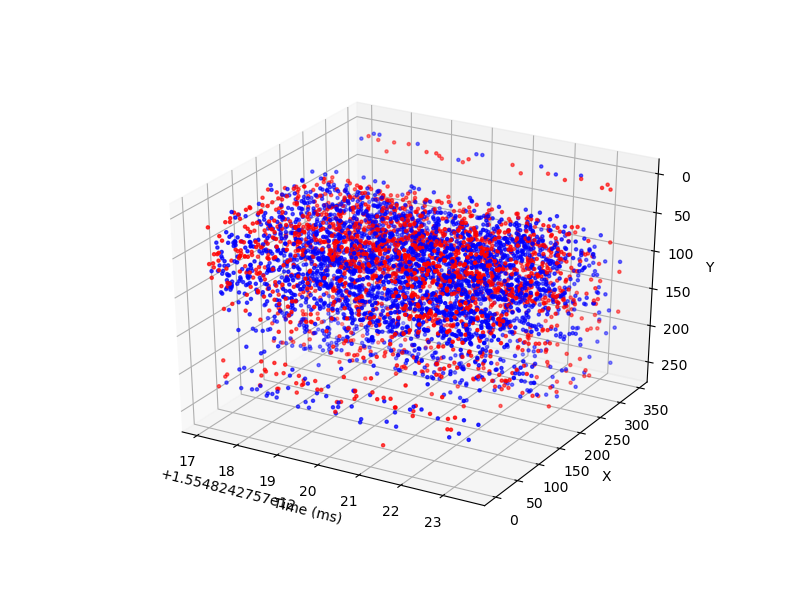

3D plot: 0.05s


In [5]:
with Timer('3D plot'):
    plot_3d(event_data, n_events=5e3)

## Event slice

Use the sliders to visualize a slice of events within a time window.

In [6]:
interact(event_slice, event_data=fixed(event_data),
         start=FloatSlider(min=0, max=1, step=0.01,continuous_update=False),
         duration_ms=IntSlider(value=50, min=0, max=500, step=1, continuous_update=False));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='start', max=1.0, step=0.01)…

## Image reconstruction
Run the cell, then click ```Run Interact``` and wait for the animation to appear to see the result.  
Use the slider then click ```Run Interact``` again to try different settings.

### Leaky integrator
Equation: $L^{k+1}(x, y) = \beta L^k(x, y) + p,\ \beta \in [0, 1],\ p \in \{-1, 1\}$, where $L$ is the log image intensity and $p$ is the event polarity.

#### Set ```beta = 1``` for direct integration. Try lowering beta to see what happens.

In [7]:
interact_manual(leaky_integrator, event_data=fixed(event_data), beta=(0, 1, 0.01));

interactive(children=(FloatSlider(value=1.0, description='beta', max=1.0, step=0.01), Button(description='Run …

### High pass filter
Below is the high pass filter as described in: https://cedric-scheerlinck.github.io/files/2018_scheerlinck_continuous-time_intensity_estimation.pdf  
Equation: $L^{k+1}(x, y) = \exp(-\alpha \Delta t) L^k(x, y) + p$, where $\alpha$ is the cutoff frequency and $\Delta t$ is the time since the last event at the same pixel.

In [8]:
interact_manual(high_pass_filter, event_data=fixed(event_data), cutoff_frequency=(0, 20, 0.01));

interactive(children=(FloatSlider(value=5.0, description='cutoff_frequency', max=20.0, step=0.01), Button(desc…

### Complementary filter
Below is the complementary filter as described in: https://cedric-scheerlinck.github.io/files/2018_scheerlinck_continuous-time_intensity_estimation.pdf  
Equation: $L^{k+1}(x, y) = \exp(-\alpha \Delta t) L^k(x, y) + (1 - \exp(-\alpha \Delta t)) L_F(x, y) + p$, where $\alpha$ is the cutoff frequency, $\Delta t$ is the time since the last event at the same pixel and $L_F$ is the log intensity of the image frame from a frame-based camera, e.g., DAVIS.

In [9]:
event_data.add_frame_data('data/indoors_office/frames')

In [10]:
def complementary_filter(event_data, cutoff_frequency=5.0):
    print('Reconstructing, please wait...')
    events, height, width = event_data.event_list, event_data.height, event_data.width
    frames, frame_timestamps = event_data.frames, event_data.frame_timestamps
    events_per_frame = 2e4
    with Timer('Reconstruction'):
        time_surface = np.zeros((height, width), dtype=np.float32)
        image_state = np.zeros((height, width), dtype=np.float32)
        image_list = []
        frame_idx = 0
        max_frame_idx = len(frames) - 1
        log_frame = np.log(frames[0] + 1)
        
        # To reset timestamp
        t_o = events[0].t
        
        for i, e in enumerate(events):
            e.t = e.t - t_o
            if frame_idx < max_frame_idx:
                if e.t >= frame_timestamps[frame_idx + 1]:
                    log_frame = np.log(frames[frame_idx + 1] + 1)
                    frame_idx += 1
            beta = math.exp(-cutoff_frequency * (e.t - time_surface[e.y, e.x]))
            image_state[e.y, e.x] = beta * image_state[e.y, e.x] \
                                    + (1 - beta) * log_frame[e.y, e.x] + 0.1 * e.p
            time_surface[e.y, e.x] = e.t
            if i % events_per_frame == 0:
                beta = np.exp(-cutoff_frequency * (e.t - time_surface))
                image_state = beta * image_state + (1 - beta) * log_frame
                time_surface.fill(e.t)
                image_list.append(np.copy(image_state))
    return animate_color(image_list, 'Complementary Filter')

In [11]:
interact_manual(complementary_filter, event_data=fixed(event_data), cutoff_frequency=(0, 20, 0.01));

interactive(children=(FloatSlider(value=5.0, description='cutoff_frequency', max=20.0, step=0.01), Button(desc…